# Exploitation - 1

In the exploitation task, we aim to predict the edges and the type of edges (transport routes). We start with Hand crafted features, followed by node embedding and finally use GNNs. In this notebook, we will work using the hand-crafted features.

In [4]:
import glob
import pickle
import pathlib
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib.colors as mcolors

from enum import Enum
from tqdm import tqdm
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import svm
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.feature_selection import SelectKBest, f_classif


mcolors = list(mcolors.BASE_COLORS)

In [5]:
rel_data_folder_path = pathlib.Path("./../../data")
transport_data_path = rel_data_folder_path.joinpath('transport_data')
city_network = rel_data_folder_path.joinpath('network_graphs')
city_network_graphs = city_network.joinpath('graphs')
city_network_graphs_dir = city_network_graphs.joinpath('directed_graphs')
# city_network_graphs_undir = city_network_graphs.joinpath('undirected_graphs')
city_network_bones = city_network.joinpath('nodes-edges')

checkpoints_folder_path = rel_data_folder_path.joinpath("checkpoints")
city_network_graphs_dir_betweenness = checkpoints_folder_path.joinpath('directed_graphs_betweenness')
city_network_graphs_dir_edge_pred_linreg = checkpoints_folder_path.joinpath('linreg-single-class')

In [6]:
# Define enum for route types
class RouteType(Enum):
    tram, subway, rail, bus, ferry, cablecar, gondola = range(7)

def load_city_graphs(city_name, graphs_folder):
    with open(graphs_folder.joinpath(city_name.lower() + '.gpickle'), 'rb') as f:
        city_graph = pickle.load(f)
    return city_graph

def load_all_cities_graphs(cities: list[str], graphs_folder: pathlib.Path):
    return {city: load_city_graphs(city, graphs_folder) for city in cities}

def classifier_svm(features, targets, labels, feature_selection=False, num_features=1, test_size=0.5, seed=0, verbose=False, input_feature_names=None, title=None):
    ''' 
    INPUT:
    features: feature matrix of dimensions (N, D) (N: number of samples; D: number of features) 
    targets: target vector of dimensions (N, ) (N: number of samples)
    labels: vector of all possible labels for nodes in the graph 
    feature_selection: a flag for whether to use feature selction, bool
    num_features: number of features used from feature selesction
    test_size: please set to 0.5 for reproducibility
    seed: please set to 0 for reproducibility
    verbose: print and plot result or not, bool
    input_feature_names: Names for the input features, None by default
    title: Title for the confusion matrix

    OUTPUT:
    cm: confusion matrix on the test set
    f1: weighted f1 score on the test set

    '''

    # Split the data into training and testing sets, with test_size=0.5
    X_train, X_test, y_train, y_test = train_test_split(features, targets, stratify=targets, random_state=seed, test_size=test_size)

    if feature_selection:
        ## Build and train the ML model, including feature selection, normalization and Support Vector Classifier. Select the k highest relevant features for the classification. 
        feature_selector = SelectKBest(f_classif, k=num_features)
        X_train_sel = feature_selector.fit_transform(X_train, y_train)
        clf = make_pipeline(StandardScaler(), svm.SVC(class_weight='balanced', random_state=seed))
        clf.fit(X_train_sel, y_train)
        ## Print the scores for individual features.
        print("\nTo select the top {} features:".format(num_features))
        if not input_feature_names:
            input_feature_names = ["feature_{}".format(str(i)) for i in range(features.shape[1])]
        print("\tThe feature scorees are:")
        print("\t{}".format({ft_name:ft_score for ft_name, ft_score in zip(input_feature_names, feature_selector.scores_)}))
        print("\tThe selected features are {}".format(feature_selector.get_feature_names_out(input_features=input_feature_names)))
    else:
        ## Build and train the ML model, including normalization and Support Vector Classifier.
        clf = make_pipeline(StandardScaler(), svm.SVC(class_weight='balanced', random_state=seed))
        clf.fit(X_train, y_train)

    # Use the model to predict the labels of the test data
    if feature_selection:
        X_test_sel = feature_selector.transform(X_test)
        y_pred = clf.predict(X_test_sel)
    else:
        y_pred = clf.predict(X_test)
    # Output the confusion matrix and weighted f1 score on the test set. Print the weighted f1 score and plot the confusion matrix if verbose
    cm = metrics.confusion_matrix(y_test, y_pred, labels=labels)
    f1 = metrics.f1_score(y_test, y_pred, average='weighted')
    acc = metrics.accuracy_score(y_test, y_pred)

    if verbose:
        print("The Weighted F1 score is {}".format(f1))
        disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
        disp.plot()
        if title:
            disp.ax_.set_title(title)
        plt.show()
    return cm, f1, acc

def classifier(features, targets, labels, feature_selection=False, num_features=1, test_size=0.5, seed=0, verbose=False, input_feature_names=None, title=None):
    ''' 
    INPUT:
    features: feature matrix of dimensions (N, D) (N: number of samples; D: number of features) 
    targets: target vector of dimensions (N, ) (N: number of samples)
    labels: vector of all possible labels for nodes in the graph 
    feature_selection: a flag for whether to use feature selction, bool
    num_features: number of features used from feature selesction
    test_size: please set to 0.5 for reproducibility
    seed: please set to 0 for reproducibility
    verbose: print and plot result or not, bool
    input_feature_names: Names for the input features, None by default
    title: Title for the confusion matrix

    OUTPUT:
    cm: confusion matrix on the test set
    f1: weighted f1 score on the test set
    '''

    # Split the data into training and testing sets, with test_size=0.5
    X_train, X_test, y_train, y_test = train_test_split(features, targets, stratify=targets, random_state=seed, test_size=test_size)

    if feature_selection:
        ## Build and train the ML model, including feature selection, normalization and Support Vector Classifier. Select the k highest relevant features for the classification. 
        feature_selector = SelectKBest(f_classif, k=num_features)
        X_train_sel = feature_selector.fit_transform(X_train, y_train)
        clf = make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', random_state=seed))
        clf.fit(X_train_sel, y_train)
        ## Print the scores for individual features.
        print("\nTo select the top {} features:".format(num_features))
        if not input_feature_names:
            input_feature_names = ["feature_{}".format(str(i)) for i in range(features.shape[1])]
        print("\tThe feature scorees are:")
        print("\t{}".format({ft_name:ft_score for ft_name, ft_score in zip(input_feature_names, feature_selector.scores_)}))
        print("\tThe selected features are {}".format(feature_selector.get_feature_names_out(input_features=input_feature_names)))
    else:
        ## Build and train the ML model, including normalization and Logi.
        clf = make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', random_state=seed))
        clf.fit(X_train, y_train)

    # Use the model to predict the labels of the test data
    if feature_selection:
        X_test_sel = feature_selector.transform(X_test)
        y_pred = clf.predict(X_test_sel)
    else:
        y_pred = clf.predict(X_test)
    # Output the confusion matrix and weighted f1 score on the test set. Print the weighted f1 score and plot the confusion matrix if verbose
    cm = metrics.confusion_matrix(y_test, y_pred, labels=labels)
    f1 = metrics.f1_score(y_test, y_pred, average='weighted')
    acc = metrics.accuracy_score(y_test, y_pred)

    if verbose:
        print("\t\tThe Weighted F1 score is {}".format(f1))
        print("\t\tThe Accuracy is {}".format(acc))
        disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
        disp.plot()
        if title:
            disp.ax_.set_title(title)
        plt.show()
    return cm, f1, acc

In [7]:
cities = sorted([x.stem for x in city_network_graphs_dir.glob('*.gpickle')])
cities_graphs_dir = load_all_cities_graphs(cities, city_network_graphs_dir_betweenness)
# cities_graphs_undir = load_all_cities_graphs(cities, city_network_graphs_undir)

## Task - 1

In the first task, we predict the edges between the given nodes only when considering a single route type. 

### Hand-crafted features

For this task we consider the following node features

1. In degree centrality
2. Out degree centrality
3. Betweenness centrality
4. Katz centrality

and the following edge features
1. fraction of common predecessors among all predecessors
2. fraction of common successors among all successors

To compute the edge features between nodes, we combine the node features by subtracting the source node features from the target node features and then add the edge features.

In [ ]:
from node2vec import Node2Vec
# Node2Vec feature extraction function
def Node2Vec_node_feature_extraction(G, num_features=1, p=1.0, q=1.0, seed=0):
    """
    Extract the node2vec features from the graph

    Args:
    G: nx.Graph -> Graph input
    num_features: int -> dimensions of the node embeddings
    p: float -> return parameter, explains the likelihood of immediately revisiting a particular node
    q: float -> in-out parameter, allows search to differentiate between "inward" and "outward" nodes
    seed: please always set to 0

    Returns:
    features: feature matrix of dimensions (N, D) (N: number of samples; D: dimension of Node2Vec embeddings) 
    """

    node2vec_ = Node2Vec(G, dimensions=num_features, p=p, q=q, seed=seed)
    model = node2vec_.fit()
    features = np.array([model.wv[node] for node in G.nodes()])
    return features

In [8]:
def generate_edge_feature_targets(graph: nx.Graph) -> list[np.ndarray]:
    """
    Generate a node feature matrix for a given graph.

    Args:
        graph: The input graph.

    Returns:
        edge_features: The edge features.
        targes: target vector with values of {0, 1}
        labels: vector of all possible targets in the graph 

    """
    
    nodes = list(graph.nodes())
    num_nodes = len(nodes)
    
    edge_features = []
    targets = []
    labels = []
    
    in_degree_centrality = nx.in_degree_centrality(graph)
    out_degree_centrality = nx.out_degree_centrality(graph)
    betweenness_centrality = nx.get_node_attributes(graph, "betweenness")
    katz_centrality = nx.katz_centrality(graph)
    
    for idx1 in range(num_nodes):
        node1 = nodes[idx1]
        # Get the predecessors (incoming neighbors) of the source node
        source_predecessors = set(graph.predecessors(node1))
        # Get the successors (outgoing neighbors) of the source node
        source_successors = set(graph.successors(node1))
        node_1_feat = [
            in_degree_centrality[node1],
            out_degree_centrality[node1], 
            betweenness_centrality[node1],
            katz_centrality[node1]
        ]
        for idx2 in range(num_nodes):
            node2 = nodes[idx2]
            node_2_feat = [
                in_degree_centrality[node2],
                out_degree_centrality[node2], 
                betweenness_centrality[node2],
                katz_centrality[node2]
            ]
            
            comb_feature = np.subtract(node_2_feat, node_1_feat)
            # avg_feature = np.mean(np.array([node_1_feat, node_2_feat ]), axis=0)
            
            if idx1 == idx2:
                comm_preds = 1
                comm_succe = 1
            else:
                # Get the predecessors (incoming neighbors) of the target node
                target_predecessors = set(graph.predecessors(node2))

                # Get the successors (outgoing neighbors) of the target node
                target_successors = set(graph.successors(node2))
                
                union_predecessors = len(source_predecessors.union(target_predecessors))
                union_successors = len(source_successors.union(target_successors))
                
                if union_predecessors == 0:
                    comm_preds = 0
                else:
                    comm_preds = len(source_predecessors.intersection(target_predecessors)) / union_predecessors
                
                if union_successors == 0:
                    comm_succe = 0
                else:
                    comm_succe = len(source_successors.intersection(target_successors)) / union_successors
            
            
            edge_feature = np.concatenate((comb_feature, np.array([comm_preds, comm_succe])))
            
            edge_features.append(edge_feature)
            targets.append(1 if graph.has_edge(node1, node2) else 0)
            
    return np.array(edge_features), np.array(targets), np.unique(targets)

In [9]:
cities_reg = sorted([x.stem for x in city_network_graphs_dir_edge_pred_linreg.glob('*.gpickle')])

In [1]:
import pandas as pd
# hand_feat_names = ["in-deg", "out-deg", "betweeness", "katz", "comm-pred", "comm-succ"]

# city_network_graphs_dir_edge_pred_linreg.mkdir(parents=True, exist_ok=True)

# for city, city_graphs in tqdm(cities_graphs_dir.items()):
#     if city in cities_reg:
#         continue
#     city_graphs_scores = {}
#     print("For {} city".format(city.title()))
#     for route_type, route_graph in city_graphs.items():
#         if ((route_type in ["full"]) or (route_graph is None)):
#             continue
        
#         print("\tFor {} route".format(route_type.title()))
        
#         features_edges, targets_edge, labels_edge = generate_edge_feature_targets(route_graph)
        
#         title = "{}-{}".format(city.title(), route_type)
        
#         cm, f1score, accuracy = classifier(features_edges, targets_edge, labels_edge,
#                                  feature_selection=False, test_size=0.5,
#                                  seed=0, verbose=False, input_feature_names=hand_feat_names, title=title)
                   
#         city_graphs_scores[route_type] = {"f1": f1score, "cm": cm, "acc": accuracy}
        
#     with open(city_network_graphs_dir_edge_pred_linreg.joinpath('{}.gpickle'.format(city)), 'wb') as f:
#         pickle.dump(city_graphs_scores, f, pickle.HIGHEST_PROTOCOL)

In [2]:
cities_graphs_scores = load_all_cities_graphs(cities_reg, city_network_graphs_dir_edge_pred_linreg)

NameError: name 'load_all_cities_graphs' is not defined

In [1]:
cities_graphs_scores_df = pd.DataFrame.from_dict({(i,j): cities_graphs_scores[i][j] 
                           for i in cities_graphs_scores.keys() 
                           for j in cities_graphs_scores[i].keys()},
                       orient='index').reset_index(drop=False, names=["city", "route"])

NameError: name 'pd' is not defined

In [19]:
cities_graphs_scores_df

,city,route,f1,cm,acc
0,adelaide,tram,0.324326,"[[80, 314], [1, 26]]",0.251781
1,adelaide,rail,0.908426,"[[3345, 412], [76, 39]]",0.873967
2,adelaide,bus,0.887873,"[[20784940, 5238697], [2983, 1493]]",0.798615
3,belfast,bus,0.919854,"[[751273, 128128], [821, 243]]",0.853544
4,berlin,tram,0.926989,"[[92888, 13352], [388, 94]]",0.871254
...,...,...,...,...,...
59,turku,bus,0.990924,"[[423678, 4918], [860, 209]]",0.986552
60,venice,tram,0.431852,"[[201, 485], [8, 28]]",0.317175
61,venice,bus,0.979269,"[[524616, 19175], [807, 370]]",0.963334
62,venice,ferry,0.832914,"[[5156, 1791], [63, 71]]",0.738173


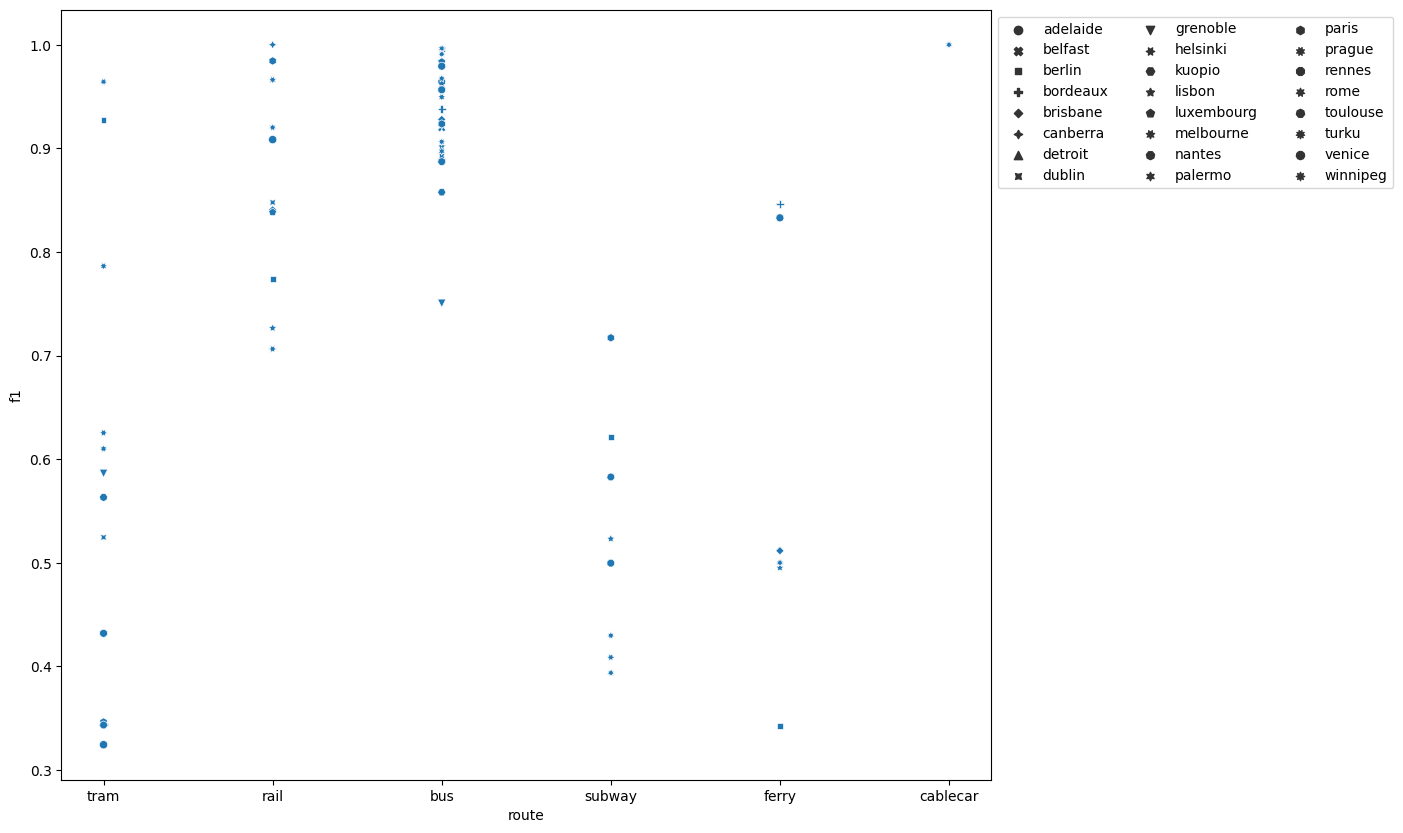

In [29]:
plt.figure(figsize=(12,10))
sns.scatterplot(data=cities_graphs_scores_df, x="route", y="f1", style="city")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=3)
# plt.yscale('log')

In [ ]:
# with open(checkpoints_folder_path.joinpath('LinReg-results.gpickle'), 'wb') as f:
#     pickle.dump(cities_graphs_scores, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
# hand_feat_names = ["in-deg", "out-deg", "betweeness", "katz", "comm-pred", "comm-succ"]
# ks = np.arange(1,len(hand_feat_names) + 1)


# cities_graphs_scores = {}

# for city, city_graphs in tqdm(cities_graphs_dir.items()):
#     cities_graphs_scores[city] = {}
#     print("For {} city".format(city.title()))
#     for route_type, route_graph in city_graphs.items():
#         if ((route_type in ["cablecar", "full"]) or (route_graph is None)):
#             continue
        
#         print("\tFor {} route".format(route_type.title()))
        
#         features_edges, targets_edge, labels_edge = generate_edge_feature_targets(route_graph)
        
#         f1_ks = []
#         cm_ks = []
#         for k in ks:
#             cm, f1score = classifier(features_edges, targets_edge, labels_edge,
#                                   feature_selection=True, num_features=k,
#                                   test_size=0.5, seed=0, verbose=False,
#                                   input_feature_names=hand_feat_names)
#             print("F1 {}".format(f1score))
#             f1_ks.append(f1score)
#             cm_ks.append(cm)            
#         cities_graphs_scores[city][route_type] = {"f1": f1_ks, "cm": cm_ks}
            

#         fig, ax = plt.subplots()
#         ax.plot(ks, f1_ks, label='F1 score')
#         ax.set_title("Weighted f1 score at different number of best K features")
#         ax.set_xlabel("K")
#         ax.set_ylabel("F1 score");
#         plt.show()

#         k_best = np.argmax(f1_ks) + 1 # add one as the indexing starts from 0
#         print("\t\tThe best K with respect to weighted f1 score is: {}".format(k_best))